## KSP Assignment 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.misc import derivative
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['text.usetex'] = True
rcParams.update({'figure.autolayout': True})

### Constants, and Newtonian approximation for frequency

In [24]:
# Masses:
M0 = 1.99*10**30 # Solar mass
m1 = 35*M0
m2 = 35*M0
Mc = np.power(m1*m2, 3/5)/np.power(m1+m2, 1/5) # Chirp mass
redM = m1*m2/(m1+m2) # Reduced mass
totM = m1+m2 # Total mass

# Universal constants
pi = np.pi
G = 6.67*10**(-11)
c = 299792458

# Distance of source from detector
D = 10^22 # Actual is ~410*30.9*10^18 m (410 Mpc)

# Initial values / scalings
h0=1
phi0 = 0
tc0 = -4/2944 # Because at t=0 we get singularities

In [25]:
# Newtonian frequency approximation
def frequencyN(t): # Valid for t<0
    return np.power( abs(np.power(8*pi,8/3)/5*np.power(G*Mc/c**3, 5/3)*(-t)) , -3/8)

In [26]:
# Other useful constants
nuM = redM/totM

def dlc(f0): # A DimensionLess Constant used in many equations
    return pi*G*totM*f0/c**3

# Coefficients of various order PN terms
def tau0(f0):
    return 5 / (256 * pi * f0 * nuM * np.power(dlc(f0), 5/3))
def tau1(f0):
    return 5 * (743/336 + 11*nuM/4)/(192 * pi * f0 * nuM * dlc(f0))
def tau1_5(f0):
    return 1 / (8 * f0 * nuM * np.power(dlc(f0), 2/3))
def tau2(f0):
    return 5 * (3058673/1016064 + 5429*nuM/1008 + 617*nuM**2/144) / (128 * pi * f0 * nuM * np.power(dlc(f0), 1/3))

### Post-Newtonian Frequency-Time relation and Derivative

In [27]:
def freqTimeRelation(f,t,t0,f0):
    
    f_rel = abs(f)/f0
    return (tau0(f0)*(1-np.power(f_rel, -8/3)) 
        + tau1(f0)*(1-np.power(f_rel, -2)) 
        - tau1_5(f0)*(1-np.power(f_rel, -5/3))
        + tau2(f0)*(1-np.power(f_rel, -4/3))
        + t0 - t )

In [28]:
def derivativeFrequencyPN(t, f,t0,f0):
    f_rel = abs(f)/f0
    return 3*f0/8/(tau0(f0))**2*np.power(f_rel, 11/3)*(tau0(f0)
                                                 - 3*tau1(f0)/4*np.power(f_rel, 2/3)
                                                 + 5*tau1_5(f0)/8*f_rel 
                                                 - (tau2(f0) - 9*(tau1(f0))**2/8/tau0(f0))*np.power(f_rel,4/3)/2)

In [29]:
def derivativeLogFrequencyPN(t, f,t0,f0):
    f_rel = abs(f)/f0
    return 3/8/(tau0(f0))**2*np.power(f_rel, 8/3)*(tau0(f0)
                                                 - 3*tau1(f0)/4*np.power(f_rel, 2/3)
                                                 + 5*tau1_5(f0)/8*f_rel 
                                                 - (tau2(f0) - 9*(tau1(f0))**2/8/tau0(f0))*np.power(f_rel,4/3)/2)

### PN Freq : Solving DE

In [30]:
def frequencyPN_DifferentialSolver(timeSeries, t0, f0):
    return solve_ivp(derivativeFrequencyPN,
                    (timeSeries[0],timeSeries[-1]),
                    y0 = [frequencyN(timeSeries[0])],
                    t_eval = timeSeries,
                    args = (t0,f0))["y"][0]

### PN Freq : Solving Implicit Eq

In [31]:
def frequencyPN_Implicit(t, t0, f0):
    return fsolve(freqTimeRelation, frequencyN(t), args = (t,t0,f0))

## Testing

Number of points resolved: 374305 
Length of Time Series: 376832 
   message: 'Required step size is less than spacing between numbers.'
     nfev: 644
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([-1.        , -0.99999764, -0.99999528, ..., -0.11597534,
       -0.11597298, -0.11597062])
 t_events: None
        y: array([[ 17.84995447,  17.84997113,  17.84998779, ..., 595.73978381,
        667.36242231, 815.47316579]])
 y_events: None


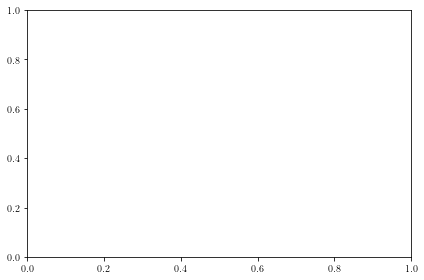

In [32]:
# timeSeriesTest = np.arange(-0.2,-0.001,32/(2944))
t0 = -1
f0 = 10
timeSeriesTest = np.linspace(-1,-0.11,128*2944, endpoint=False)
sol = solve_ivp(derivativeFrequencyPN,
                (timeSeriesTest[0],timeSeriesTest[-1]),
                y0 = [frequencyN(timeSeriesTest[0])],
                t_eval = timeSeriesTest,
                args = (t0,f0))
try:
    plt.plot(timeSeriesTest, sol["y"][0])
except:
    pass
print("Number of points resolved:", len(sol["y"][0]),"\nLength of Time Series:", len(timeSeriesTest),"\n", sol)

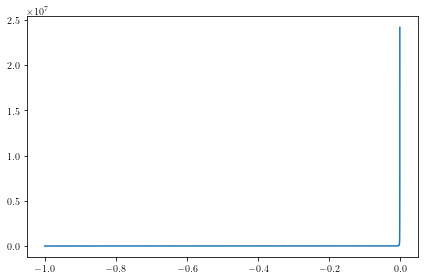

In [33]:
timeSeriesTest = np.linspace(-1,0,4*2944, endpoint=False)
t0 = -1
f0 = 10
dfSeriesTest = []
for i in range(len(timeSeriesTest)):
    t = timeSeriesTest[i]
    dfSeriesTest.append(derivativeFrequencyPN(t, frequencyN(t),t0,f0))
plt.plot(timeSeriesTest, dfSeriesTest)

[-1.000e+00 -9.999e-01 -9.998e-01 ... -3.000e-04 -2.000e-04 -1.000e-04]


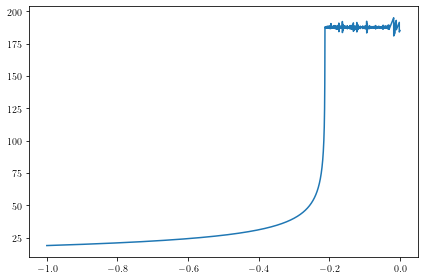

In [42]:
timeSeriesTest = np.linspace(-1,0,10000, endpoint=False)
print(timeSeriesTest)

t0 = -1
f0 = 19

freqSeries = []
# freqSeries = [frequencyPN_Implicit(t) for t in timeSeriesTest]
for t in timeSeriesTest:
    sol = fsolve(freqTimeRelation, 1, args = (t,t0,f0), full_output=True)
    # print(sol)
    freqSeries.append(sol[0])
plt.plot(timeSeriesTest, freqSeries)

## A different approach - Obtaining time from frequency

In [35]:
def timeAtFreqPN(f, f0, t0):
    
    f_rel = abs(f)/f0
    return (tau0(f0)*(1-np.power(f_rel, -8/3)) 
        + tau1(f0)*(1-np.power(f_rel, -2)) 
        - tau1_5(f0)*(1-np.power(f_rel, -5/3))
        + tau2(f0)*(1-np.power(f_rel, -4/3))
        + t0)

In [36]:
def timeAtFreqN(f, f0, t0):
    return t0 + 5/np.power(8*pi,8/3)*np.power(c**3/G/Mc, 5/3)*(np.power(f0, -8/3) - np.power(f, -8/3))

In [37]:
def timeAtFreqN2(f, f0, t0):
    f_rel = abs(f)/f0
    return (tau0(f0)*(1-np.power(f_rel, -8/3)) + t0)

In [56]:
# f_ISCO = sqrt(G*totM/a_ISCO^3) gives the following :
print("calculated f_ISCO : ", c**3/(G*Mc*np.sqrt(6**3)*pi))

f_ISCO = 145 # This is just a guess
print("Guess used : ", f_ISCO)

calculated f_ISCO :  144.29271494384594
Guess used :  145


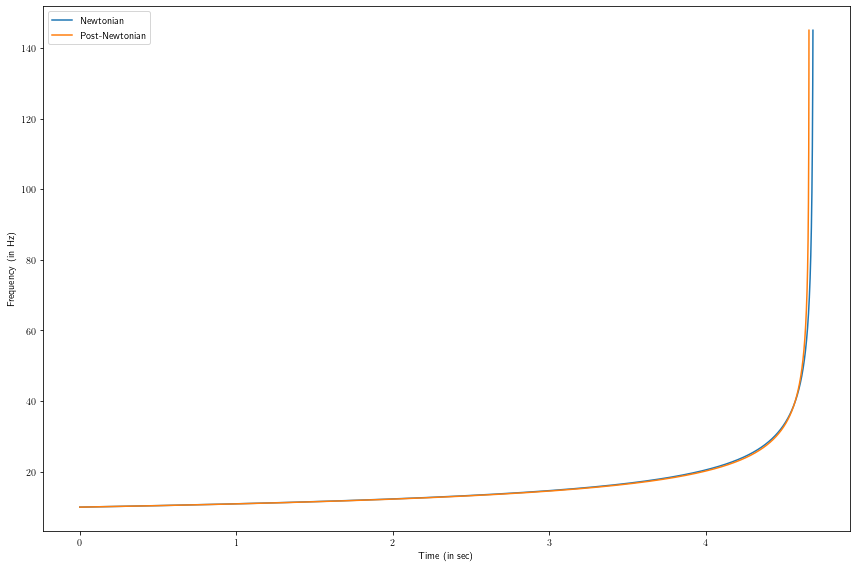

In [48]:
f0 = 10
t0 = 0

freqSeriesTest = np.linspace(f0,f_ISCO,10000, endpoint=False)
logFreqSeriesTest = np.log(freqSeriesTest)
timeSeries1 = [timeAtFreqN(f, f0, t0) for f in freqSeriesTest]
timeSeries2 = [timeAtFreqPN(f, f0, t0) for f in freqSeriesTest]
# timeSeries3 = [timeAtFreqN2(f, f0, t0) for f in freqSeriesTest]
plt.figure(figsize=(12,8), facecolor=(1,1,1))
plt.plot(timeSeries1, freqSeriesTest, label = "Newtonian")
plt.plot(timeSeries2, freqSeriesTest, label = "Post-Newtonian")
# plt.plot(timeSeries3, freqSeriesTest, label = "Newtonian - Implicit")
plt.legend()

plt.ylabel("Frequency (in Hz)")
plt.xlabel("Time (in sec)")

plt.savefig('Frequency_time_comparison.png', dpi = 300)
plt.show()

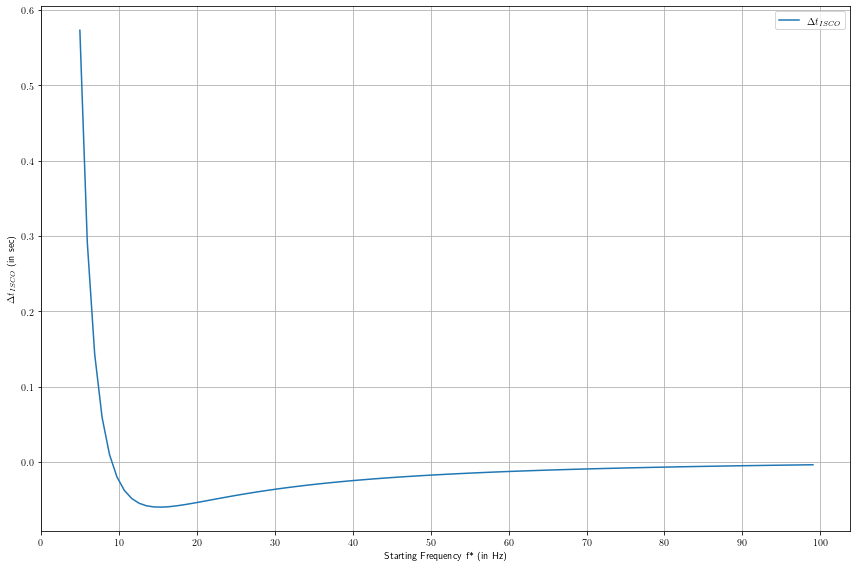

In [50]:
freqStartSeries = np.linspace(5,100,100,endpoint=False)

timeISCO_PN = np.array([(timeAtFreqPN(f_ISCO,x,0)) for x in freqStartSeries])
timeISCO_N = np.array([(timeAtFreqN(f_ISCO,x,0)) for x in freqStartSeries])
timeDiff = timeISCO_PN - timeISCO_N

plt.figure(figsize=(12,8), facecolor=(1,1,1))

plt.plot(freqStartSeries, timeDiff, label="$\Delta t_{ISCO}$") 

plt.xlabel("Starting Frequency f* (in Hz)")
plt.ylabel("$\Delta t_{ISCO}$ (in sec)")
plt.legend()
plt.xticks(ticks = np.arange(0,110, 10))
# plt.yticks(ticks = np.arange(-0.1,0.7,0.1))

plt.grid(True)
plt.savefig('Delta_t_ISCO_plot.png', dpi = 300)
plt.show()


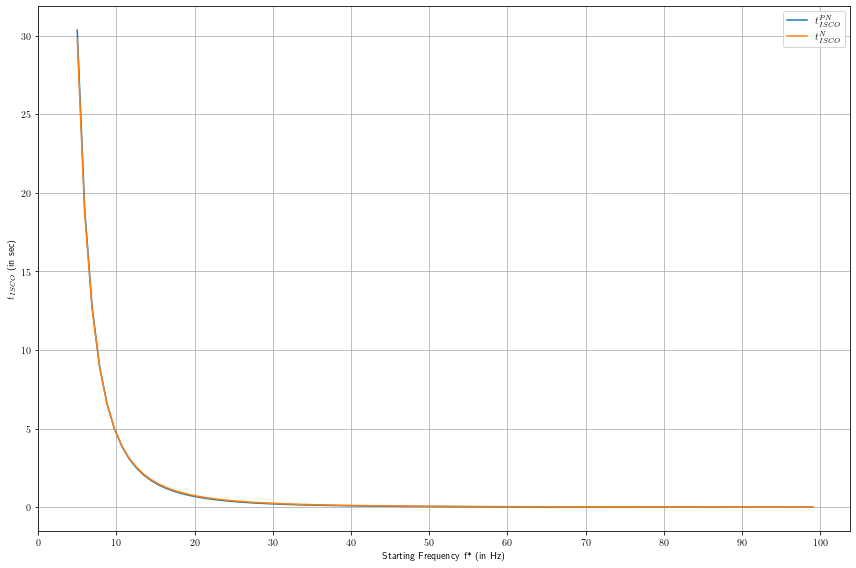

In [51]:
plt.figure(figsize=(12,8), facecolor=(1,1,1))

plt.plot(freqStartSeries, timeISCO_PN, label="$t^{PN}_{ISCO}$") 
plt.plot(freqStartSeries, timeISCO_N, label="$t^N_{ISCO}$") 


plt.xlabel("Starting Frequency f* (in Hz)")
plt.ylabel("$t_{ISCO}$ (in sec)")
plt.legend()
plt.xticks(ticks = np.arange(0,110, 10))
# plt.yticks(ticks = np.arange(-5,50,5))

plt.grid(True)
plt.savefig('t_ISCO_plots.png', dpi = 300)
plt.show()